In [1]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import metrics
from sklearn import naive_bayes
from sklearn import svm
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Classify pirate attacks

Use KNN, Naive Bayes and SVM on the Pirate Attacks dataset to predict pirate attack success:

* Clean and preprocess data using a one-hot-encoder for categorical variables.
* Run the three models on the data.
* Which model is the best in predicting attacks?

## Read data

In [2]:
attacks = pd.read_csv('pirate-attacks.csv', index_col=0)
attacks.head()

,DATETIME (LOCAL),DATETIME (UTC),DATE (LT),DATE (UTC),REGION,COUNTRY,INCIDENT TYPE,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,LAT,LONG,TIMEZONE,TIME OF DAY,ATTACKS,ATTACK SUCCESS
1,2016-01-30 23:34:00,2016-01-30 22:34:00,2016-01-30,2016-01-30,WEST AFRICA,NIGERIA,"FAILED ATTACK, HIJACKING",CONTAINER SHIP,0,OFF SHORE,3.000000,6.250000,Africa/Lagos,EVENING,1,0
2,2016-01-29 23:40:00,2016-01-29 22:40:00,2016-01-29,2016-01-29,WEST AFRICA,NIGERIA,KIDNAP/RANSOM AT SEA,PRODUCT TANKER,0,OFF SHORE,2.500000,5.750000,Africa/Lagos,EVENING,1,1
3,2016-01-28 03:00:00,2016-01-28 02:00:00,2016-01-28,2016-01-28,SOUTH ASIA,INDIA,"FAILED ATTACK, ROBBERY",PRODUCT TANKER,0,ANCHORAGE,22.816667,70.116667,Asia/Kolkata,NIGHT,1,0
4,NaN,NaN,2016-01-27,2016-01-27,HORN OF AFRICA/ GULF OF ADEN,SOMALIA,SUSPICIOUS ACTIVITY AT SEA,NaN,0,OFF SHORE,13.998747,54.112792,Asia/Riyadh,UNKNOWN,1,0
5,2016-01-25 23:55:00,2016-01-25 22:55:00,2016-01-25,2016-01-25,SOUTH AMERICA,VENEZUELA,THEFT AT ANCHORAGE,GENERAL CARGO VESSEL,0,ANCHORAGE,10.267500,-63.432500,America/Caracas,EVENING,1,1


In [3]:
attacks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 1 to 802
Data columns (total 16 columns):
DATETIME (LOCAL)            582 non-null object
DATETIME (UTC)              582 non-null object
DATE (LT)                   802 non-null object
DATE (UTC)                  802 non-null object
REGION                      802 non-null object
COUNTRY                     802 non-null object
INCIDENT TYPE               802 non-null object
VESSEL TYPE                 638 non-null object
MAERSK?                     802 non-null int64
VESSEL ACTIVITY LOCATION    676 non-null object
LAT                         802 non-null float64
LONG                        802 non-null float64
TIMEZONE                    802 non-null object
TIME OF DAY                 802 non-null object
ATTACKS                     802 non-null int64
ATTACK SUCCESS              802 non-null int64
dtypes: float64(2), int64(3), object(11)
memory usage: 106.5+ KB


In [4]:
attacks['ATTACK SUCCESS'].value_counts()

1    500
0    302
Name: ATTACK SUCCESS, dtype: int64

In [5]:
attacks['ATTACKS'].value_counts()

1    802
Name: ATTACKS, dtype: int64

In [6]:
attacks['MAERSK?'].value_counts()

0    794
1      8
Name: MAERSK?, dtype: int64

In [7]:
attacks.loc[pd.isnull(attacks['DATETIME (LOCAL)']), 'TIME OF DAY'].value_counts()

UNKNOWN    178
MORNING     25
EVENING     17
Name: TIME OF DAY, dtype: int64

## Harmless preprocessing

In a first instance, we will perform some pre-processing steps not depending on the distribution of the data or patterns found in the data.

* Delete column `DATETIME (UTC)` as it is essentially repeating information found in column `DATETIME (LOCAL)`
* Replace column `DATETIME (LOCAL)` by `ATTACK HOUR`, i.e. the hour at which the attack took place in order not to repeat information contained in column `DATE (LT)`
* Whenever possible, fill NA `ATTACK HOUR` by the mean hour of the time of day the attack took place
* Delete column `DATE (UTC)` as it is essentially repeating information found in column `DATE (LT)`
* Delete column `INCIDENT TYPE` as it leaks information on whether the attack was succesful (incident type is known only after the incident has taken place
* Delete column `ATTACKS` as it always equal to one
* Create a `ATTACK MONTH` column (since we want to predict the future, we should not use year as feature)
* Create a `ATTACK WEEKDAY` column
* Reduce the number of vessel types, countries and timezones
* Replace `UNKNOWN` by `NaN`.

In [8]:
attacks_clean = attacks.copy()

# Convert to datetime, extract hour, month and weekday
attacks_clean['DATE (LT)'] = pd.to_datetime(attacks_clean['DATE (LT)'])
attacks_clean['DATETIME (LOCAL)'] = pd.to_datetime(attacks_clean['DATETIME (LOCAL)'])
attacks_clean['ATTACK HOUR'] = attacks_clean['DATETIME (LOCAL)'].dt.hour
attacks_clean['ATTACK MONTH'] = attacks_clean['DATE (LT)'].dt.month
attacks_clean['ATTACK WEEKDAY'] = attacks_clean['DATE (LT)'].dt.weekday

# Delete certain columns
cols_to_delete = ['DATETIME (UTC)','DATETIME (LOCAL)','DATE (UTC)','INCIDENT TYPE','ATTACKS']
attacks_clean.drop(columns=cols_to_delete, inplace=True)

# Reduce number of unique vessel types, countries and timezones
def other_out(col):
    count = attacks_clean[col].value_counts()
    rare = count[count<20]
    rare = list(rare.index)
    attacks_clean[col] = attacks_clean[col].replace(rare,'OTHER')
other_out('VESSEL TYPE')
other_out('COUNTRY')
other_out('TIMEZONE')

attacks_clean.head()

,DATE (LT),REGION,COUNTRY,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,LAT,LONG,TIMEZONE,TIME OF DAY,ATTACK SUCCESS,ATTACK HOUR,ATTACK MONTH,ATTACK WEEKDAY
1,2016-01-30,WEST AFRICA,NIGERIA,CONTAINER SHIP,0,OFF SHORE,3.000000,6.250000,Africa/Lagos,EVENING,0,23.0,1,5
2,2016-01-29,WEST AFRICA,NIGERIA,PRODUCT TANKER,0,OFF SHORE,2.500000,5.750000,Africa/Lagos,EVENING,1,23.0,1,4
3,2016-01-28,SOUTH ASIA,INDIA,PRODUCT TANKER,0,ANCHORAGE,22.816667,70.116667,Asia/Kolkata,NIGHT,0,3.0,1,3
4,2016-01-27,HORN OF AFRICA/ GULF OF ADEN,OTHER,NaN,0,OFF SHORE,13.998747,54.112792,Asia/Riyadh,UNKNOWN,0,NaN,1,2
5,2016-01-25,SOUTH AMERICA,OTHER,GENERAL CARGO VESSEL,0,ANCHORAGE,10.267500,-63.432500,OTHER,EVENING,1,23.0,1,0


In [9]:
# Replace attack hour by mean morning hour when attack takes place in morning
attacks_clean.loc[(attacks_clean['TIME OF DAY']=='MORNING') & (pd.isnull(attacks_clean['ATTACK HOUR'])), 'ATTACK HOUR'] \
= round(attacks_clean.loc[attacks_clean['TIME OF DAY'] == 'MORNING', 'ATTACK HOUR'].mean(),0)

# Replace attack hour by mean evening hour when attack takes place in the evening
attacks_clean.loc[(attacks_clean['TIME OF DAY']=='EVENING') & (pd.isnull(attacks_clean['ATTACK HOUR'])), 'ATTACK HOUR'] \
= round(attacks_clean.loc[attacks_clean['TIME OF DAY'] == 'EVENING', 'ATTACK HOUR'].mean(),0)

# Replace UNKNOWNs by NaN
attacks_clean.loc[attacks_clean['TIME OF DAY']=='UNKNOWN', 'TIME OF DAY'] = None
attacks_clean.loc[attacks_clean['VESSEL TYPE']=='UNKNOWN', 'VESSEL TYPE'] = None

attacks_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 1 to 802
Data columns (total 14 columns):
DATE (LT)                   802 non-null datetime64[ns]
REGION                      802 non-null object
COUNTRY                     802 non-null object
VESSEL TYPE                 638 non-null object
MAERSK?                     802 non-null int64
VESSEL ACTIVITY LOCATION    676 non-null object
LAT                         802 non-null float64
LONG                        802 non-null float64
TIMEZONE                    802 non-null object
TIME OF DAY                 624 non-null object
ATTACK SUCCESS              802 non-null int64
ATTACK HOUR                 624 non-null float64
ATTACK MONTH                802 non-null int64
ATTACK WEEKDAY              802 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(6)
memory usage: 94.0+ KB


## Split the data into train and test

In [10]:
train_set, test_set = model_selection.train_test_split(attacks_clean, test_size=0.2, random_state=25)
train_set.shape, test_set.shape

((641, 14), (161, 14))

## Exploratory data analysis

I create a dataset where successes and failures are balanced in order to more easily compare counts (rather than calculate proportions every time).

In [11]:
train_set['ATTACK SUCCESS'].value_counts()

1    399
0    242
Name: ATTACK SUCCESS, dtype: int64

In [12]:
train_set_success = train_set[train_set['ATTACK SUCCESS']==1]
train_set_failure = train_set[train_set['ATTACK SUCCESS']==0]
train_set_success = train_set_success.sample(train_set['ATTACK SUCCESS'].value_counts()[0], replace=False)
train_eda = pd.concat([train_set_success, train_set_failure], sort=False)
train_eda['ATTACK SUCCESS'].value_counts()

1    242
0    242
Name: ATTACK SUCCESS, dtype: int64

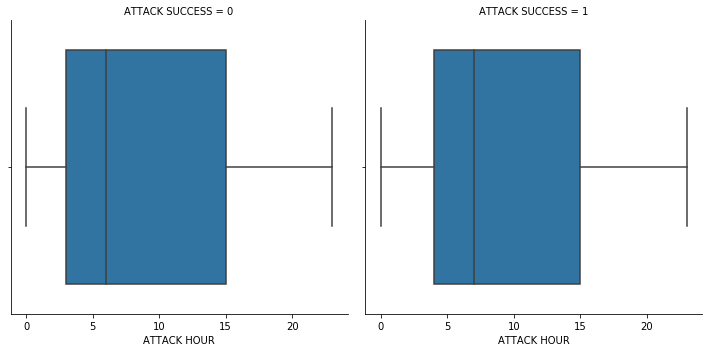

In [13]:
sns.catplot('ATTACK HOUR', data=train_set, col='ATTACK SUCCESS', kind="box")

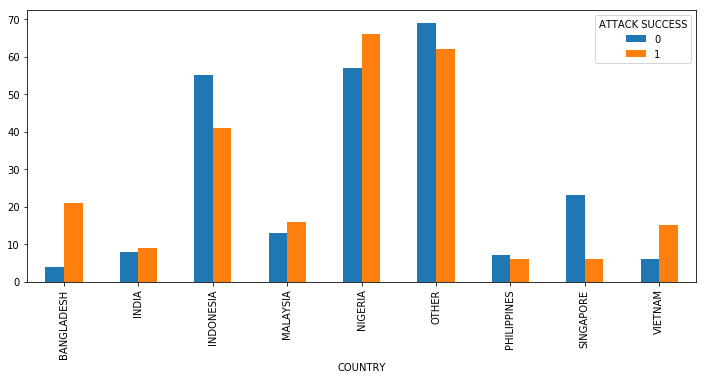

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
pd.crosstab(train_eda['COUNTRY'], train_eda['ATTACK SUCCESS']).plot(kind='bar', stacked=False, ax=ax);

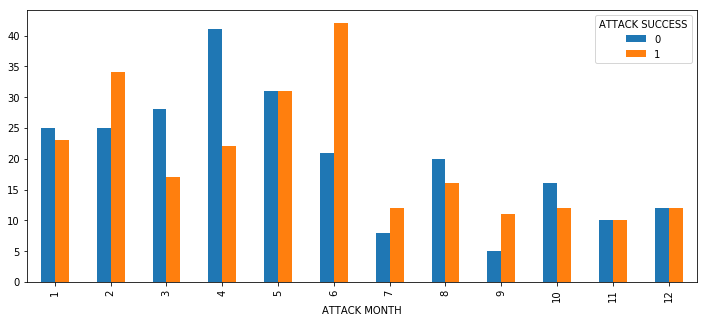

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))
pd.crosstab(train_eda['ATTACK MONTH'], train_eda['ATTACK SUCCESS']).plot(kind='bar', stacked=False, ax=ax);

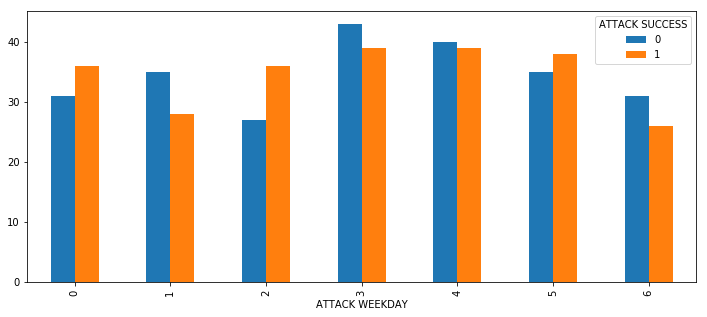

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))
pd.crosstab(train_eda['ATTACK WEEKDAY'], train_eda['ATTACK SUCCESS']).plot(kind='bar', stacked=False, ax=ax);

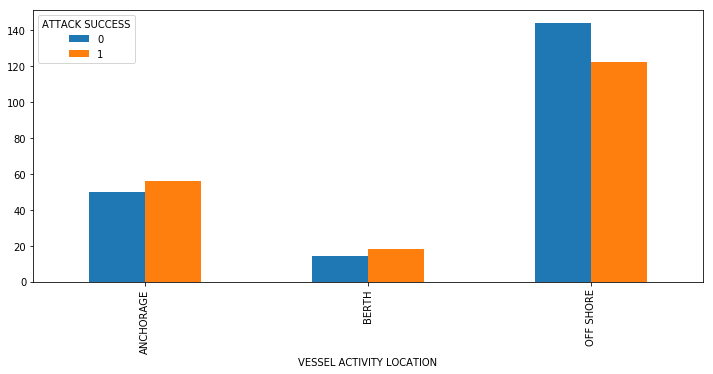

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))
pd.crosstab(train_eda['VESSEL ACTIVITY LOCATION'], train_eda['ATTACK SUCCESS']).plot(kind='bar', stacked=False, ax=ax);

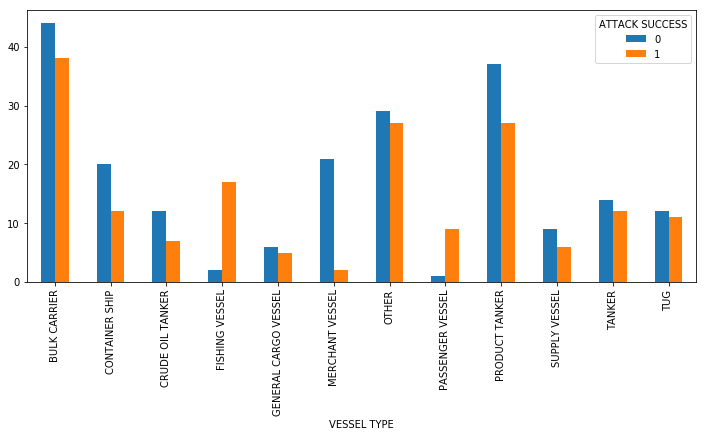

In [18]:
fig, ax = plt.subplots(figsize=(12, 5))
pd.crosstab(train_eda['VESSEL TYPE'], train_eda['ATTACK SUCCESS']).plot(kind='bar', stacked=False, ax=ax);

The type of vessel seems to be highly relevant as some types lead to either high rates of success or failures.

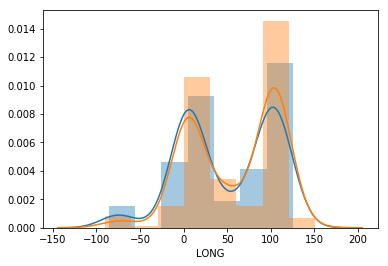

In [19]:
sns.distplot(train_eda[train_eda['ATTACK SUCCESS']==1]['LONG'])
sns.distplot(train_eda[train_eda['ATTACK SUCCESS']==0]['LONG']);

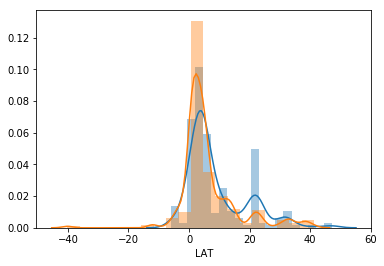

In [20]:
sns.distplot(train_eda[train_eda['ATTACK SUCCESS']==1]['LAT'], bins=20)
sns.distplot(train_eda[train_eda['ATTACK SUCCESS']==0]['LAT'], bins=20);

In [21]:
pd.crosstab(train_set['MAERSK?'], train_set['ATTACK SUCCESS'])

ATTACK SUCCESS,0,1
MAERSK?,,
0,240,394
1,2,5


There are very few attacks on Maersk vessels and these are successful in the same proportion as other attacks, we will therefore not use this column.

## Preprocessing

KNN, naive Bayes and SVM require the data to be scaled.

In [22]:
train_set.columns

Index(['DATE (LT)', 'REGION', 'COUNTRY', 'VESSEL TYPE', 'MAERSK?',
       'VESSEL ACTIVITY LOCATION', 'LAT', 'LONG', 'TIMEZONE', 'TIME OF DAY',
       'ATTACK SUCCESS', 'ATTACK HOUR', 'ATTACK MONTH', 'ATTACK WEEKDAY'],
      dtype='object')

In [23]:
# Features selection
num_cols_to_keep = []#['LAT', 'LONG']
cat_cols_to_keep = ['REGION', 'COUNTRY', 'VESSEL TYPE', 'VESSEL ACTIVITY LOCATION','ATTACK HOUR', 'ATTACK MONTH'] #'ATTACK WEEKDAY'
y_col = ['ATTACK SUCCESS']
cols_to_keep = num_cols_to_keep + cat_cols_to_keep + y_col

# Drop rows with NAs
train = train_set[cols_to_keep].dropna()
test = test_set[cols_to_keep].dropna()

# Preparation of y
y_train = train[y_col].values.reshape(-1,1)
y_test = test[y_col].values.reshape(-1,1)

# Preparation of numeric columns
if len(num_cols_to_keep)>0:
    X_num_train = train[num_cols_to_keep].values
    X_num_test = test[num_cols_to_keep].values
    minmax = preprocessing.MinMaxScaler()
    X_num_train = minmax.fit_transform(X_num_train)
    X_num_test = minmax.transform(X_num_test)
else:
    X_num_train = np.empty(len(train)).reshape(-1,1)
    X_num_test = np.empty(len(test)).reshape(-1,1)
    
# Preparation of categorical columns
X_cat_train = train[cat_cols_to_keep].values
X_cat_test = test[cat_cols_to_keep].values
onehot = preprocessing.OneHotEncoder(sparse=False)
X_cat_train = onehot.fit_transform(X_cat_train)
X_cat_test = onehot.transform(X_cat_test)

#Concatenation of numeric and categorical 
X_train = np.concatenate((X_num_train, X_cat_train), axis=1)
X_test = np.concatenate((X_num_test, X_cat_test), axis=1)

X_train.shape, X_num_train.shape, X_cat_train.shape, y_train.shape

((414, 73), (414, 1), (414, 72), (414, 1))

## Fit different classifiers
### KNN

In [24]:
KNN = neighbors.KNeighborsClassifier(n_neighbors=7)
KNN.fit(X_train,y_train.ravel())
y_train_pred = KNN.predict(X_train)
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.70      0.63      0.66       180
           1       0.74      0.79      0.76       234

   micro avg       0.72      0.72      0.72       414
   macro avg       0.72      0.71      0.71       414
weighted avg       0.72      0.72      0.72       414



In [25]:
y_test_pred = KNN.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59        47
           1       0.73      0.76      0.74        70

   micro avg       0.68      0.68      0.68       117
   macro avg       0.67      0.67      0.67       117
weighted avg       0.68      0.68      0.68       117



In [26]:
print(metrics.accuracy_score(y_test, y_test_pred))

0.6837606837606838


### Naive Bayes

In [27]:
NB = naive_bayes.BernoulliNB()
NB.fit(X_train,y_train.ravel())
y_train_pred = NB.predict(X_train)
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.60      0.65      0.62       180
           1       0.71      0.67      0.69       234

   micro avg       0.66      0.66      0.66       414
   macro avg       0.66      0.66      0.66       414
weighted avg       0.66      0.66      0.66       414



In [28]:
y_test_pred = NB.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.42      0.47      0.44        47
           1       0.62      0.57      0.59        70

   micro avg       0.53      0.53      0.53       117
   macro avg       0.52      0.52      0.52       117
weighted avg       0.54      0.53      0.53       117



In [29]:
print(metrics.accuracy_score(y_test, y_test_pred))

0.5299145299145299


### SVM
#### Linear SVC (C = 1)

In [30]:
lin_svm = svm.LinearSVC()
lin_svm.fit(X_train,y_train.ravel())
y_train_pred = lin_svm.predict(X_train)
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65       180
           1       0.73      0.76      0.75       234

   micro avg       0.71      0.71      0.71       414
   macro avg       0.70      0.70      0.70       414
weighted avg       0.70      0.71      0.70       414



In [31]:
y_test_pred = lin_svm.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52        47
           1       0.68      0.70      0.69        70

   micro avg       0.62      0.62      0.62       117
   macro avg       0.61      0.61      0.61       117
weighted avg       0.62      0.62      0.62       117



In [32]:
print(metrics.accuracy_score(y_test, y_test_pred))

0.6239316239316239


#### Linear SVC (C = grid-searched)

In [33]:
parameters = {'C': np.linspace(0.001, 1, 100)}
lin_svm_best = svm.LinearSVC()
grid_search = model_selection.GridSearchCV(lin_svm_best, parameters)
grid_search.fit(X_train, y_train.ravel())
lin_svm_best = grid_search.best_estimator_
lin_svm_best

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LinearSVC(C=0.011090909090909092, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [34]:
y_train_pred = lin_svm_best.predict(X_train)
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59       180
           1       0.69      0.80      0.74       234

   micro avg       0.68      0.68      0.68       414
   macro avg       0.68      0.67      0.67       414
weighted avg       0.68      0.68      0.68       414



In [35]:
y_test_pred = lin_svm_best.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.49      0.40      0.44        47
           1       0.64      0.71      0.68        70

   micro avg       0.59      0.59      0.59       117
   macro avg       0.56      0.56      0.56       117
weighted avg       0.58      0.59      0.58       117



In [36]:
print(metrics.accuracy_score(y_test, y_test_pred))

0.5897435897435898


#### SVC (grid-searched)

In [37]:
parameters = {'C': np.linspace(0.001, 1, 10), 
              'kernel': ['linear', 'poly', 'rbf']}
svm_best = svm.SVC(gamma='scale')
grid_search = model_selection.GridSearchCV(svm_best, parameters)
grid_search.fit(X_train, y_train.ravel())
svm_best = grid_search.best_estimator_
svm_best

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


SVC(C=0.667, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
y_train_pred = svm_best.predict(X_train)
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.82      0.58      0.68       180
           1       0.74      0.90      0.81       234

   micro avg       0.76      0.76      0.76       414
   macro avg       0.78      0.74      0.74       414
weighted avg       0.77      0.76      0.75       414



In [39]:
y_test_pred = svm_best.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.52      0.36      0.43        47
           1       0.64      0.77      0.70        70

   micro avg       0.61      0.61      0.61       117
   macro avg       0.58      0.57      0.56       117
weighted avg       0.59      0.61      0.59       117



In [40]:
print(metrics.accuracy_score(y_test, y_test_pred))

0.6068376068376068
